# Testing Transformer performance on CIFAR10 challenge according to different channel size
Trying to make the Encoder_MultiheadedAttention.py work for the CIFAR 10 challenge. 


In [2]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import math

#from Encoder_MultiheadedAttention import Encoder

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

cuda


Files already downloaded and verified
Files already downloaded and verified


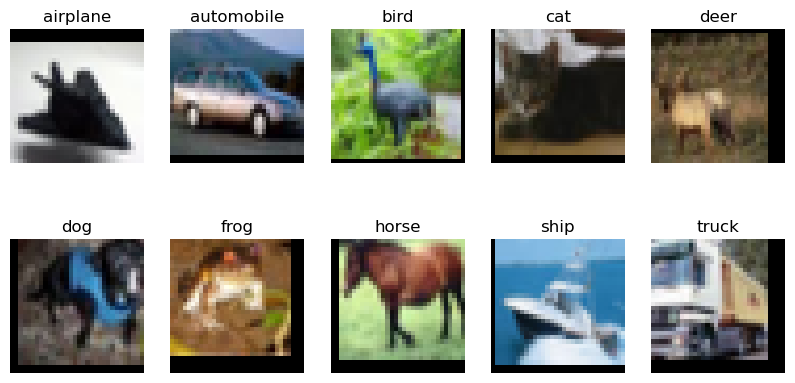

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

batch_size = 128

# Download and load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create imbalanced traindataset
num_samples_per_class = {k:(k+1)*500 for k in range(10)}
class_to_indices = {cls: np.where(np.array(trainset.targets) == cls)[0] for cls in range(10)}
imbalanced_indices = []
for cls, count in num_samples_per_class.items():
    indices = class_to_indices[cls][:count]  # Select the first `count` samples
    imbalanced_indices.extend(indices)
imbalanced_trainset = Subset(trainset, imbalanced_indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()

In [4]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            #print("Output: ", outputs[12])
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #print("Total: ", total)
            correct += (predicted == labels).sum().item()
    return correct / total

def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_init = validate(model, testloader, device)
    print(f"Accuracy before Training: {acc_init}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader): 
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            preds = model(inputs)
            
            
            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [5]:
class Attention(nn.Module): 
    def __init__(self, dim_1, dim_2): 
        super(Attention, self).__init__()
        self.K = nn.Linear(dim_1, dim_2, bias=False)
        self.Q = nn.Linear(dim_1, dim_2, bias=False)
        self.V = nn.Linear(dim_1, dim_2, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x): 
        #print("X: ", x.size())
        scores = self.K(x) @ self.Q(x).transpose(-2, -1)
        #print("scores: ", scores.size())
        att_weight = self.softmax(scores / np.sqrt(x.shape[-1]))
        #print("att_weight", att_weight.size())
        out = att_weight @ self.V(x)
        #print("out weight: ", out.size())
        return out

class MultiHeadAttention(nn.Module): 
    def __init__(self, dim_1, dim_2, num_heads): 
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList(Attention(dim_1, dim_2) for _ in range(num_heads))
        self.Z = nn.Linear(num_heads * dim_1, dim_1)

    def forward(self, x): 
        #print(x.size())
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        #print(out.size())
        return self.Z(out)
    
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, max_len=32):
        super(PositionalEncoding2D, self).__init__()
        pe = torch.zeros(d_model, max_len, max_len)
        pos_x = torch.arange(max_len).unsqueeze(1)
        pos_y = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe[:, :, 0::2] = torch.sin(pos_x * div_term).unsqueeze(1)
        pe[:, :, 1::2] = torch.cos(pos_y * div_term).unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :x.size(2), :x.size(3)]
    
class EncoderLayer(nn.Module):
    def __init__(self, dim_1, head_size, num_heads, ff_size): 
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(dim_1, head_size, num_heads)
        self.layer_norm = nn.LayerNorm(dim_1)
        self.dropout = nn.Dropout(p=0.2)
        self.ff = nn.Sequential(
            nn.Linear(dim_1, ff_size), 
            nn.GELU(), 
            nn.Linear(ff_size, dim_1)
        )  
    
    def forward(self, x): 
        out = x + self.mha(x)
        #out = self.dropout(out)
        out = self.layer_norm(out)
        temp = out
        out = temp + self.ff(out)
        out = self.layer_norm(out)
        return out

class Encoder(nn.Module): 
    def __init__(self, dim, head_size, num_heads, ff_size, num_encoders, num_classes): 
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(EncoderLayer(dim_1=dim, head_size=head_size, num_heads=num_heads, ff_size=ff_size) for _ in range(num_encoders))
        self.pe = PositionalEncoding2D(dim, max_len=32)
        self.linear = nn.Linear(dim, num_classes)
    
    def forward(self, x): 
        x = x + self.pe(x)
        for layer in self.layers: 
            x = layer(x)
        #print("X size: ", x.size())
        x = x.mean(dim=1) 
        x = x.mean(dim=1)
        out = self.linear(x)
        #print("Out size: ", out.size())
        return self.linear(x)


In [6]:
# Get one image from the dataset
image, label = trainset[0]

dim_1 = image.size(dim=1)
dim_2 = image.size(dim=2)
K = nn.Linear(dim_1, dim_2, bias=False)
Q = nn.Linear(dim_1, dim_2, bias=False)
V = nn.Linear(dim_1, dim_2, bias=False)
softmax = nn.Softmax(dim=-1)

scores = K(image) @ Q(image)
att_weight = softmax(scores / np.sqrt(image.shape[-1]))
out = att_weight @ V(image)


channel, x, y = out.size()
pos_x = torch.arange(x, device=out.device)
pos_y = torch.arange(y, device=out.device)
# Einfach erstmal zwei for schleifen die über alle channel alles iterieren? 

div_term_x = torch.exp(torch.arange(0, x, 2).float() * (-math.log(10000.0) / x))
div_term_y = torch.exp(torch.arange(0, y, 2).float() * (-math.log(10000.0) / y))

sin_inp_x = torch.sin(torch.einsum("i,j->ij", pos_x, div_term_x))
sin_inp_y = torch.cos(torch.einsum("i,j->ij", pos_y, div_term_y))

pe = torch.zeros(channel, x, y)

print(sin_inp_x.size())
print(sin_inp_y.size())

pe[:, :, 0::2 ] = torch.sin(sin_inp_x)
pe[:, :, 1::2] = torch.cos(sin_inp_y)



torch.Size([32, 16])
torch.Size([32, 16])


In [7]:
num_heads = 12  # Example number of heads
image, label = trainset[0]
dim_1 = image.size(dim=1)
dim_2 = image.size(dim=2)
# Initialize the Encoder model with the calculated dimensions
model = Encoder(dim=dim_1, head_size=dim_2, num_heads=num_heads, ff_size=1024, num_encoders=10, num_classes=10)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)

train(model, trainloader, testloader, criterion, optimizer, num_epochs=100, device=device)

Accuracy before Training: 0.1084


100%|██████████| 215/215 [00:24<00:00,  8.77it/s]

Epoch 1, loss: 2.0440113012180774


Accuracy on train set: 0.3336
Accuracy on test set: 0.2127


100%|██████████| 215/215 [00:24<00:00,  8.66it/s]

Epoch 2, loss: 1.8593040133631507


Accuracy on train set: 0.37876363636363636
Accuracy on test set: 0.2624


100%|██████████| 215/215 [00:24<00:00,  8.70it/s]

Epoch 3, loss: 1.7807932643003241


Accuracy on train set: 0.3957090909090909
Accuracy on test set: 0.2692


100%|██████████| 215/215 [00:24<00:00,  8.76it/s]

Epoch 4, loss: 1.7231655730757602


Accuracy on train set: 0.42461818181818184
Accuracy on test set: 0.2836


100%|██████████| 215/215 [00:24<00:00,  8.69it/s]

Epoch 5, loss: 1.674245825479197


Accuracy on train set: 0.4418909090909091
Accuracy on test set: 0.2991


100%|██████████| 215/215 [00:24<00:00,  8.62it/s]

Epoch 6, loss: 1.6323568116786868


Accuracy on train set: 0.45174545454545456
Accuracy on test set: 0.3072


100%|██████████| 215/215 [00:24<00:00,  8.85it/s]

Epoch 7, loss: 1.6066973442255064


Accuracy on train set: 0.4536363636363636
Accuracy on test set: 0.3092


100%|██████████| 215/215 [00:24<00:00,  8.63it/s]

Epoch 8, loss: 1.5707673083904177


Accuracy on train set: 0.47243636363636365
Accuracy on test set: 0.3179


100%|██████████| 215/215 [00:25<00:00,  8.53it/s]

Epoch 9, loss: 1.549628681360289


Accuracy on train set: 0.48105454545454546
Accuracy on test set: 0.3287


100%|██████████| 215/215 [00:24<00:00,  8.82it/s]

Epoch 10, loss: 1.528443747343019


Accuracy on train set: 0.49003636363636366
Accuracy on test set: 0.344


100%|██████████| 215/215 [00:25<00:00,  8.53it/s]

Epoch 11, loss: 1.5054228732752246


Accuracy on train set: 0.4954181818181818
Accuracy on test set: 0.3415


100%|██████████| 215/215 [00:25<00:00,  8.57it/s]

Epoch 12, loss: 1.4898263581963473


Accuracy on train set: 0.5017090909090909
Accuracy on test set: 0.361


100%|██████████| 215/215 [00:24<00:00,  8.69it/s]

Epoch 13, loss: 1.472728852893031


Accuracy on train set: 0.5059272727272728
Accuracy on test set: 0.362


100%|██████████| 215/215 [00:24<00:00,  8.73it/s]

Epoch 14, loss: 1.459786812094755


Accuracy on train set: 0.5118909090909091
Accuracy on test set: 0.3586


100%|██████████| 215/215 [00:24<00:00,  8.64it/s]

Epoch 15, loss: 1.4445587269095488


Accuracy on train set: 0.5160363636363636
Accuracy on test set: 0.3651


100%|██████████| 215/215 [00:24<00:00,  8.66it/s]

Epoch 16, loss: 1.4316069907920306


Accuracy on train set: 0.5206545454545455
Accuracy on test set: 0.3641


100%|██████████| 215/215 [00:25<00:00,  8.52it/s]

Epoch 17, loss: 1.4175726896108582


Accuracy on train set: 0.5224727272727273
Accuracy on test set: 0.3613


100%|██████████| 215/215 [00:24<00:00,  8.73it/s]

Epoch 18, loss: 1.4037045395651528


Accuracy on train set: 0.5241818181818182
Accuracy on test set: 0.3667


100%|██████████| 215/215 [00:24<00:00,  8.73it/s]

Epoch 19, loss: 1.392102059652639


Accuracy on train set: 0.5296
Accuracy on test set: 0.382


100%|██████████| 215/215 [00:25<00:00,  8.56it/s]

Epoch 20, loss: 1.3864414414694144


Accuracy on train set: 0.5234909090909091
Accuracy on test set: 0.3765


100%|██████████| 215/215 [00:24<00:00,  8.68it/s]

Epoch 21, loss: 1.3795966087385665


Accuracy on train set: 0.5329454545454545
Accuracy on test set: 0.3887


100%|██████████| 215/215 [00:24<00:00,  8.60it/s]

Epoch 22, loss: 1.365238050527351


Accuracy on train set: 0.5319272727272727
Accuracy on test set: 0.382


100%|██████████| 215/215 [00:25<00:00,  8.59it/s]

Epoch 23, loss: 1.3590267846750659


Accuracy on train set: 0.5357454545454545
Accuracy on test set: 0.3809


100%|██████████| 215/215 [00:24<00:00,  8.69it/s]

Epoch 24, loss: 1.3551160878913346


Accuracy on train set: 0.5450545454545455
Accuracy on test set: 0.3856


100%|██████████| 215/215 [00:24<00:00,  8.61it/s]

Epoch 25, loss: 1.3414484816928243


Accuracy on train set: 0.5485818181818182
Accuracy on test set: 0.3928


100%|██████████| 215/215 [00:24<00:00,  8.64it/s]

Epoch 26, loss: 1.3354011707527693


Accuracy on train set: 0.5425818181818182
Accuracy on test set: 0.3928


100%|██████████| 215/215 [00:25<00:00,  8.58it/s]

Epoch 27, loss: 1.329264529915743


Accuracy on train set: 0.5496363636363636
Accuracy on test set: 0.3911


100%|██████████| 215/215 [00:24<00:00,  8.62it/s]

Epoch 28, loss: 1.3175240433493325


Accuracy on train set: 0.5546181818181818
Accuracy on test set: 0.3947


100%|██████████| 215/215 [00:24<00:00,  8.63it/s]

Epoch 29, loss: 1.311500603376433


Accuracy on train set: 0.5529818181818181
Accuracy on test set: 0.3902


100%|██████████| 215/215 [00:24<00:00,  8.91it/s]

Epoch 30, loss: 1.3021033869233243


Accuracy on train set: 0.5572727272727273
Accuracy on test set: 0.402


100%|██████████| 215/215 [00:24<00:00,  8.73it/s]

Epoch 31, loss: 1.296493593482084


Accuracy on train set: 0.5581818181818182
Accuracy on test set: 0.4


100%|██████████| 215/215 [00:24<00:00,  8.68it/s]

Epoch 32, loss: 1.2865192169366881


Accuracy on train set: 0.56
Accuracy on test set: 0.4062


100%|██████████| 215/215 [00:24<00:00,  8.85it/s]

Epoch 33, loss: 1.28344358732534


Accuracy on train set: 0.5624
Accuracy on test set: 0.4063


100%|██████████| 215/215 [00:25<00:00,  8.50it/s]

Epoch 34, loss: 1.276610343400822


Accuracy on train set: 0.5682545454545455
Accuracy on test set: 0.4219


100%|██████████| 215/215 [00:24<00:00,  8.77it/s]

Epoch 35, loss: 1.2677413657654164


Accuracy on train set: 0.5646909090909091
Accuracy on test set: 0.4293


100%|██████████| 215/215 [00:25<00:00,  8.57it/s]

Epoch 36, loss: 1.2575833315073057


Accuracy on train set: 0.5718181818181818
Accuracy on test set: 0.4277


100%|██████████| 215/215 [00:24<00:00,  8.87it/s]

Epoch 37, loss: 1.2506278914074564


Accuracy on train set: 0.5648363636363636
Accuracy on test set: 0.43


100%|██████████| 215/215 [00:24<00:00,  8.70it/s]

Epoch 38, loss: 1.2477184090503426


Accuracy on train set: 0.5739272727272727
Accuracy on test set: 0.43


100%|██████████| 215/215 [00:24<00:00,  8.65it/s]

Epoch 39, loss: 1.2417193396146908


Accuracy on train set: 0.5788
Accuracy on test set: 0.4469


100%|██████████| 215/215 [00:25<00:00,  8.55it/s]

Epoch 40, loss: 1.2398950726486915


Accuracy on train set: 0.5793818181818182
Accuracy on test set: 0.4298


100%|██████████| 215/215 [00:25<00:00,  8.55it/s]

Epoch 41, loss: 1.2312713711760765


Accuracy on train set: 0.5763636363636364
Accuracy on test set: 0.4386


100%|██████████| 215/215 [00:25<00:00,  8.60it/s]

Epoch 42, loss: 1.2177875058595524


Accuracy on train set: 0.5814181818181818
Accuracy on test set: 0.4379


100%|██████████| 215/215 [00:25<00:00,  8.57it/s]

Epoch 43, loss: 1.2165980122810187


Accuracy on train set: 0.5667272727272727
Accuracy on test set: 0.4257


100%|██████████| 215/215 [00:24<00:00,  8.63it/s]

Epoch 44, loss: 1.2244992605475493


Accuracy on train set: 0.5843272727272727
Accuracy on test set: 0.4455


100%|██████████| 215/215 [00:24<00:00,  8.83it/s]

Epoch 45, loss: 1.2161304180012193


Accuracy on train set: 0.5821818181818181
Accuracy on test set: 0.4431


100%|██████████| 215/215 [00:24<00:00,  8.60it/s]

Epoch 46, loss: 1.2053701203922893


Accuracy on train set: 0.5912
Accuracy on test set: 0.4503


100%|██████████| 215/215 [00:24<00:00,  8.63it/s]

Epoch 47, loss: 1.1987312846405562


Accuracy on train set: 0.5942545454545455
Accuracy on test set: 0.4406


100%|██████████| 215/215 [00:24<00:00,  8.75it/s]

Epoch 48, loss: 1.1898622629254363


Accuracy on train set: 0.5944
Accuracy on test set: 0.4582


100%|██████████| 215/215 [00:24<00:00,  8.68it/s]

Epoch 49, loss: 1.1908708444861478


Accuracy on train set: 0.5922181818181819
Accuracy on test set: 0.456


100%|██████████| 215/215 [00:24<00:00,  8.73it/s]

Epoch 50, loss: 1.1855647644331289


Accuracy on train set: 0.5908727272727273
Accuracy on test set: 0.468


100%|██████████| 215/215 [00:24<00:00,  8.68it/s]

Epoch 51, loss: 1.1760312066521756


Accuracy on train set: 0.5977454545454546
Accuracy on test set: 0.4637


100%|██████████| 215/215 [00:24<00:00,  8.67it/s]

Epoch 52, loss: 1.175472979767378


Accuracy on train set: 0.5989454545454546
Accuracy on test set: 0.461


100%|██████████| 215/215 [00:24<00:00,  8.91it/s]

Epoch 53, loss: 1.169624064134997


Accuracy on train set: 0.6006181818181818
Accuracy on test set: 0.4651


100%|██████████| 215/215 [00:23<00:00,  9.06it/s]

Epoch 54, loss: 1.1715357018071553


Accuracy on train set: 0.6038545454545454
Accuracy on test set: 0.4716


100%|██████████| 215/215 [00:24<00:00,  8.85it/s]

Epoch 55, loss: 1.162812372141106


Accuracy on train set: 0.6037090909090909
Accuracy on test set: 0.4509


100%|██████████| 215/215 [00:24<00:00,  8.84it/s]

Epoch 56, loss: 1.1638690859772438


Accuracy on train set: 0.5999636363636364
Accuracy on test set: 0.468


100%|██████████| 215/215 [00:24<00:00,  8.89it/s]

Epoch 57, loss: 1.1571667208228


Accuracy on train set: 0.6012727272727273
Accuracy on test set: 0.4411


100%|██████████| 215/215 [00:24<00:00,  8.84it/s]

Epoch 58, loss: 1.155425158766813


Accuracy on train set: 0.6075272727272727
Accuracy on test set: 0.4575


100%|██████████| 215/215 [00:24<00:00,  8.61it/s]

Epoch 59, loss: 1.1454369669736817


Accuracy on train set: 0.6119636363636364
Accuracy on test set: 0.477


100%|██████████| 215/215 [00:24<00:00,  8.63it/s]

Epoch 60, loss: 1.1434819870216901


Accuracy on train set: 0.6105454545454545
Accuracy on test set: 0.4694


100%|██████████| 215/215 [00:24<00:00,  8.73it/s]

Epoch 61, loss: 1.1377752176550933


Accuracy on train set: 0.6128363636363636
Accuracy on test set: 0.4816


100%|██████████| 215/215 [00:24<00:00,  8.82it/s]

Epoch 62, loss: 1.1392608343168746


Accuracy on train set: 0.6118545454545454
Accuracy on test set: 0.4639


100%|██████████| 215/215 [00:24<00:00,  8.61it/s]

Epoch 63, loss: 1.126881137836811


Accuracy on train set: 0.6137090909090909
Accuracy on test set: 0.4923


100%|██████████| 215/215 [00:25<00:00,  8.58it/s]

Epoch 64, loss: 1.1285109467284624


Accuracy on train set: 0.6077454545454546
Accuracy on test set: 0.4723


100%|██████████| 215/215 [00:24<00:00,  8.83it/s]

Epoch 65, loss: 1.1263170181318771


Accuracy on train set: 0.6156
Accuracy on test set: 0.4873


100%|██████████| 215/215 [00:24<00:00,  8.85it/s]

Epoch 66, loss: 1.1280311445857203


Accuracy on train set: 0.6219272727272728
Accuracy on test set: 0.4807


100%|██████████| 215/215 [00:24<00:00,  8.81it/s]

Epoch 67, loss: 1.1136459037315014


Accuracy on train set: 0.6159272727272728
Accuracy on test set: 0.4735


100%|██████████| 215/215 [00:25<00:00,  8.59it/s]

Epoch 68, loss: 1.1090771492137466


Accuracy on train set: 0.6145090909090909
Accuracy on test set: 0.4866


100%|██████████| 215/215 [00:24<00:00,  8.70it/s]

Epoch 69, loss: 1.1037531855494478


Accuracy on train set: 0.6154545454545455
Accuracy on test set: 0.4721


100%|██████████| 215/215 [00:24<00:00,  8.82it/s]

Epoch 70, loss: 1.102458452901175


Accuracy on train set: 0.6187272727272727
Accuracy on test set: 0.4895


100%|██████████| 215/215 [00:25<00:00,  8.49it/s]

Epoch 71, loss: 1.0997846933298332


Accuracy on train set: 0.6255636363636363
Accuracy on test set: 0.4825


100%|██████████| 215/215 [00:24<00:00,  8.64it/s]

Epoch 72, loss: 1.100985920151999


Accuracy on train set: 0.6284727272727273
Accuracy on test set: 0.4922


100%|██████████| 215/215 [00:24<00:00,  8.85it/s]

Epoch 73, loss: 1.0970439253851425


Accuracy on train set: 0.6210181818181818
Accuracy on test set: 0.5025


100%|██████████| 215/215 [00:24<00:00,  8.62it/s]

Epoch 74, loss: 1.0876642396283704


Accuracy on train set: 0.6255636363636363
Accuracy on test set: 0.4867


100%|██████████| 215/215 [00:25<00:00,  8.52it/s]

Epoch 75, loss: 1.0826931947885559


Accuracy on train set: 0.6298909090909091
Accuracy on test set: 0.4858


100%|██████████| 215/215 [00:24<00:00,  8.94it/s]

Epoch 76, loss: 1.0817496934602426


Accuracy on train set: 0.6281454545454546
Accuracy on test set: 0.4823


100%|██████████| 215/215 [00:25<00:00,  8.55it/s]

Epoch 77, loss: 1.0809876536214074


Accuracy on train set: 0.6299636363636364
Accuracy on test set: 0.4968


100%|██████████| 215/215 [00:24<00:00,  8.66it/s]

Epoch 78, loss: 1.072382272398749


Accuracy on train set: 0.6312
Accuracy on test set: 0.5029


100%|██████████| 215/215 [00:24<00:00,  8.68it/s]

Epoch 79, loss: 1.0711887376252995


Accuracy on train set: 0.6300363636363636
Accuracy on test set: 0.4988


100%|██████████| 215/215 [00:25<00:00,  8.54it/s]

Epoch 80, loss: 1.0663779463878897


Accuracy on train set: 0.6265090909090909
Accuracy on test set: 0.488


100%|██████████| 215/215 [00:25<00:00,  8.51it/s]

Epoch 81, loss: 1.0643397760945696


Accuracy on train set: 0.638
Accuracy on test set: 0.4976


100%|██████████| 215/215 [00:24<00:00,  8.67it/s]

Epoch 82, loss: 1.0670299507850824


Accuracy on train set: 0.638109090909091
Accuracy on test set: 0.5032


100%|██████████| 215/215 [00:24<00:00,  8.62it/s]

Epoch 83, loss: 1.0551895438238632


Accuracy on train set: 0.6273454545454545
Accuracy on test set: 0.507


100%|██████████| 215/215 [00:24<00:00,  8.66it/s]

Epoch 84, loss: 1.0564056271730466


Accuracy on train set: 0.6346909090909091
Accuracy on test set: 0.5013


100%|██████████| 215/215 [00:24<00:00,  8.80it/s]

Epoch 85, loss: 1.0562997055608172


Accuracy on train set: 0.6379272727272727
Accuracy on test set: 0.5165


100%|██████████| 215/215 [00:25<00:00,  8.47it/s]

Epoch 86, loss: 1.0532919118570727


Accuracy on train set: 0.6390545454545454
Accuracy on test set: 0.5007


100%|██████████| 215/215 [00:25<00:00,  8.50it/s]

Epoch 87, loss: 1.0488868075747824


Accuracy on train set: 0.6414181818181818
Accuracy on test set: 0.5193


100%|██████████| 215/215 [00:24<00:00,  8.69it/s]

Epoch 88, loss: 1.0360788370287695


Accuracy on train set: 0.6444
Accuracy on test set: 0.5043


100%|██████████| 215/215 [00:25<00:00,  8.53it/s]

Epoch 89, loss: 1.0423347484233767


Accuracy on train set: 0.6424363636363636
Accuracy on test set: 0.499


100%|██████████| 215/215 [00:24<00:00,  8.72it/s]

Epoch 90, loss: 1.040969634610553


Accuracy on train set: 0.6477818181818182
Accuracy on test set: 0.5155


100%|██████████| 215/215 [00:24<00:00,  8.65it/s]

Epoch 91, loss: 1.036358825550523


Accuracy on train set: 0.6480727272727272
Accuracy on test set: 0.5199


100%|██████████| 215/215 [00:25<00:00,  8.52it/s]

Epoch 92, loss: 1.031055155743


Accuracy on train set: 0.6484727272727273
Accuracy on test set: 0.5088


100%|██████████| 215/215 [00:25<00:00,  8.60it/s]

Epoch 93, loss: 1.0240637355072553


Accuracy on train set: 0.6448
Accuracy on test set: 0.518


100%|██████████| 215/215 [00:24<00:00,  8.60it/s]

Epoch 94, loss: 1.0211796876996062


Accuracy on train set: 0.6524727272727273
Accuracy on test set: 0.5291


100%|██████████| 215/215 [00:25<00:00,  8.59it/s]

Epoch 95, loss: 1.0249171778213146


Accuracy on train set: 0.6453818181818182
Accuracy on test set: 0.5165


100%|██████████| 215/215 [00:25<00:00,  8.57it/s]

Epoch 96, loss: 1.0184352761091189


Accuracy on train set: 0.6527272727272727
Accuracy on test set: 0.5266


100%|██████████| 215/215 [00:25<00:00,  8.49it/s]

Epoch 97, loss: 1.0124500723772272


Accuracy on train set: 0.6553454545454546
Accuracy on test set: 0.5153


100%|██████████| 215/215 [00:24<00:00,  8.67it/s]

Epoch 98, loss: 1.015319391184075


Accuracy on train set: 0.6512
Accuracy on test set: 0.5212


100%|██████████| 215/215 [00:24<00:00,  8.69it/s]

Epoch 99, loss: 1.0070477956949277


Accuracy on train set: 0.6566181818181818
Accuracy on test set: 0.5278


100%|██████████| 215/215 [00:24<00:00,  8.84it/s]

Epoch 100, loss: 1.0039173004239104


Accuracy on train set: 0.657309090909091
Accuracy on test set: 0.5436


In [8]:
torch.save(model.state_dict(), 'model.pth')


In [9]:
model = Encoder(dim=dim_1, head_size=dim_2, num_heads=num_heads, ff_size=1024, num_encoders=10, num_classes=10).to(device)
model.load_state_dict(torch.load('model.pth', weights_only=True))
model.eval()
validate(model, testloader, device)

0.5436